## Анализ пользовательского поведения в мобильном приложении

### Чтение данных

In [1]:
# Загружаем необходимые библиотеки

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from plotly import graph_objects as go

In [2]:
# Читаем данные

try:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [3]:
# Выведем основную информацию

display(logs.info())
logs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


В наших данных содержится 244126 записей.  
Пропусков не обнаружено.  
Тип данных со временем события требует преобразования.  
Для удобства анализа названия столбцов следует изменить.  
Также требуется проверить данные на дубликаты и уникальность значений.

### Подготовка данных

In [4]:
# Преобразуем названия колонок 

logs.columns = ['event_name', 'user_id', 'event_timestamp','group_id']
logs.head()

,event_name,user_id,event_timestamp,group_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
# Создадим столбцы datetime и date из данных столбца event_timestamp

logs['date_time'] = pd.to_datetime(logs['event_timestamp'], unit='s')
logs['date'] = pd.to_datetime(logs['date_time'].dt.date)


# Удалим столбец event_timestamp

logs = logs.drop(columns='event_timestamp')
logs.head()

,event_name,user_id,group_id,date_time,date
0,MainScreenAppear,4575588528974610257,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,248,2019-07-25 11:48:42,2019-07-25


В результате процесса подготовки данных мы поменяли названия колонок, создали два новых столбца с временной меткой и датой и удалили ненужный столбец.

### Изучение и проверка данных

In [6]:
# Проверим данные на явные дубликаты

print('Количество обнаруженных дубликатов строк: ', logs.duplicated().sum())

Количество обнаруженных дубликатов строк:  413


In [7]:
# Удалим дубликаты

logs = logs.drop_duplicates().reset_index(drop=True)
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   group_id    243713 non-null  int64         
 3   date_time   243713 non-null  datetime64[ns]
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [8]:
# Посмотрим сколько разных событий есть в логах

num_events = logs['event_name'].nunique()

print('Число уникальных событий: ', num_events)

Число уникальных событий:  5


In [9]:
# Рассмотрим статистику распределения событий на пользователя

events_per_user = logs.groupby('user_id').agg(event_count = ('event_name', 'count')).reset_index()
events_per_user['event_count'].describe().to_frame()

,event_count
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


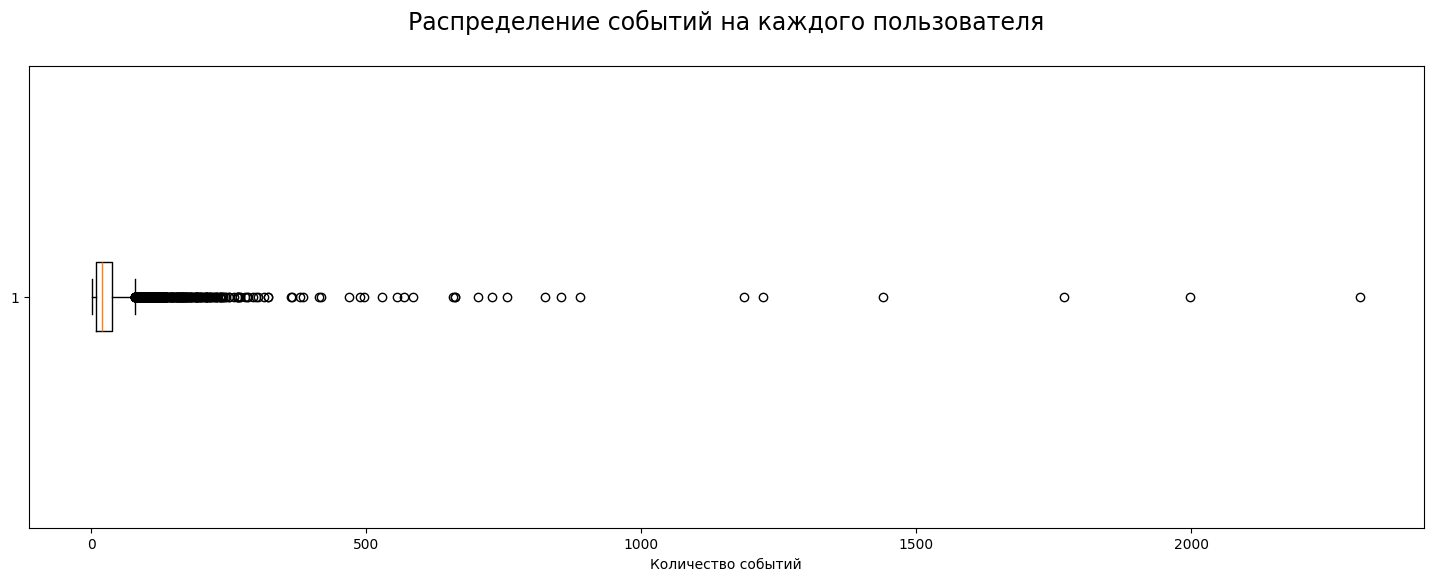

In [10]:
# Построим диаграмму размаха

plt.figure(figsize=(18, 6))
plt.boxplot(events_per_user['event_count'], vert=False)
plt.xlabel('Количество событий')
plt.title('Распределение событий на каждого пользователя' + "\n", fontsize=17);
plt.show()

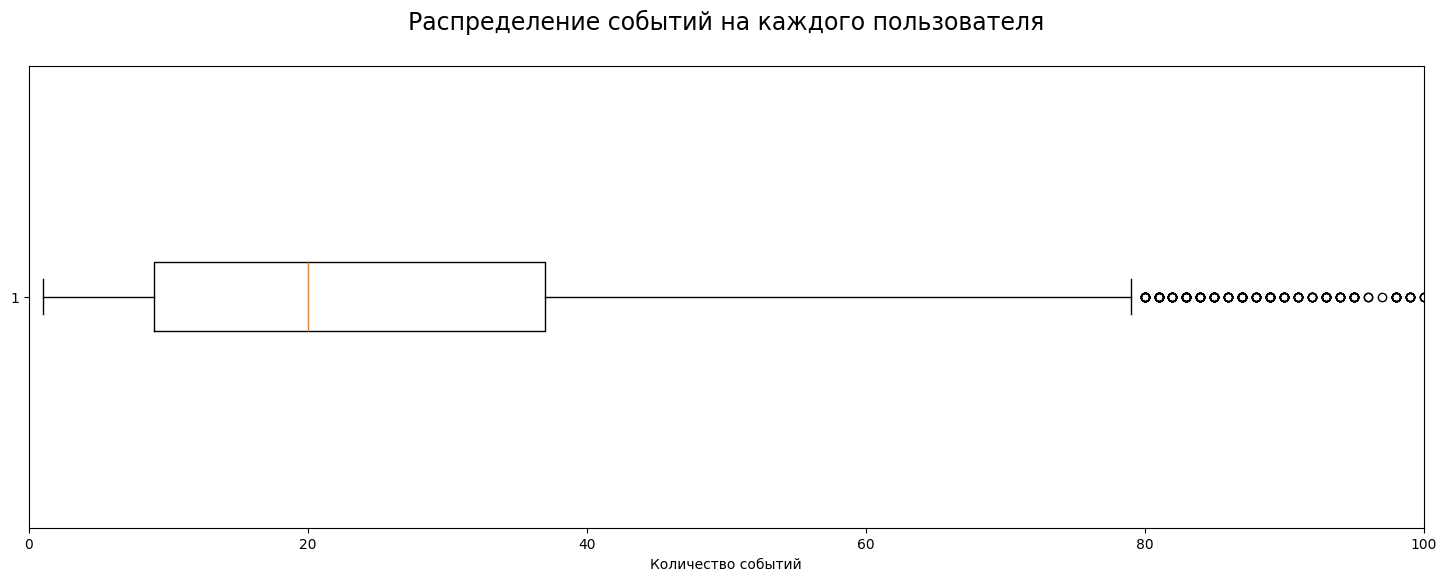

In [11]:
# Увеличм диаграмму

plt.figure(figsize=(18, 6))
plt.boxplot(events_per_user['event_count'], vert=False)
plt.xlabel('Количество событий')
plt.title('Распределение событий на каждого пользователя' + "\n", fontsize=17);
plt.xlim(0, 100)
plt.show()

В среднем на каждого из 7551 пользователя приходится 32 события. Причём, максимальное значение достигает 2307 событий на одного пользователя, минимальное - 1. Медиана значений - 20 событий. Четвёртый квартиль составляют значения с цифрой более 37 событий на пользователя.

In [12]:
# Выведем уникальные группы

logs['group_id'].unique()

array([246, 248, 247], dtype=int64)

In [13]:
# Проверим диапазон date_time

date_df = logs['date_time'].describe().loc[['min', 'max']]

print('Минимальная дата диапазона: ', date_df['min'])
print('Максимальная дата диапазона: ', date_df['max'])

Минимальная дата диапазона:  2019-07-25 04:43:36
Максимальная дата диапазона:  2019-08-07 21:15:17


Посмотрим не присутствуют ли одни и те же пользователи сразу в нескольких группах

In [14]:
duplicates = logs[logs.duplicated('user_id', keep=False)]['user_id']
result = logs[logs['user_id'].isin(duplicates)].groupby('user_id')['group_id'].nunique()
result = result[result > 1]
result.count()

0

Изучим изменение количества данных со временем.  
Построим столбчатые диаграммы, которые отобразят количество событий в зависимости от времени в разрезе групп.

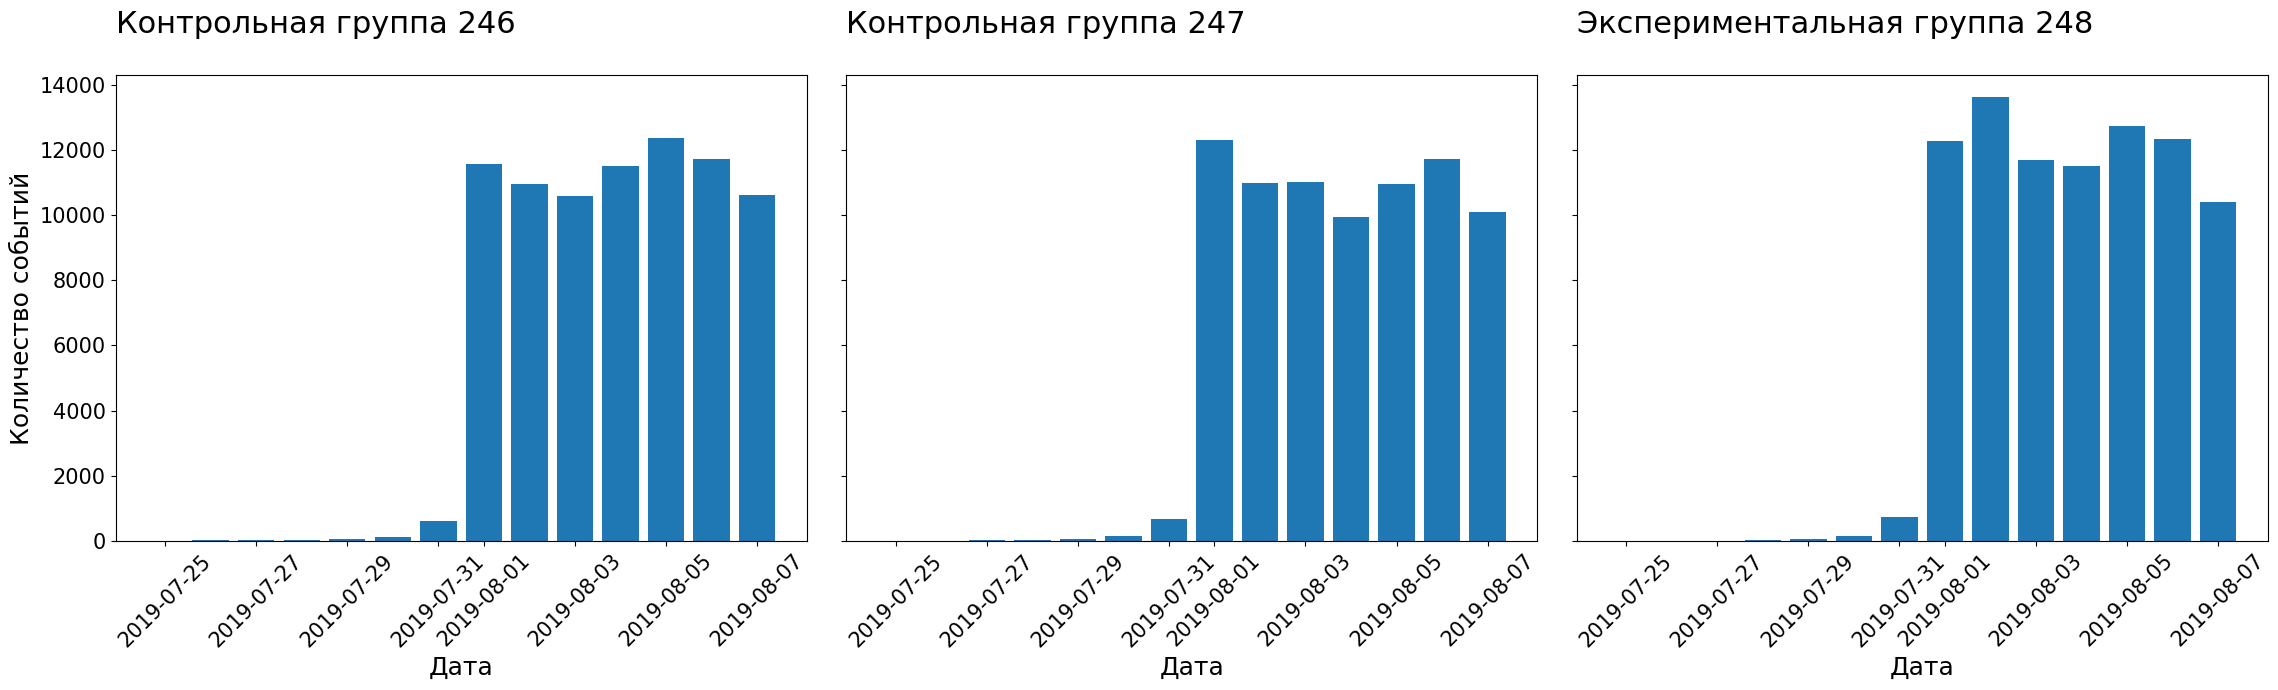

In [15]:
def plot_grouped_events(logs):
    fig, axs = plt.subplots(1, 3, figsize=(23, 7), sharey=True)

    # Первая диаграмма (Группа 246)
    event_time_246 = logs[logs['group_id']==246].groupby('date').agg({'date_time':'count'}).reset_index()
    axs[0].bar(event_time_246['date'], event_time_246['date_time'])
    axs[0].set_title('Контрольная группа 246' + "\n", fontsize=22, loc='left')
    axs[0].set_xlabel('Дата', fontsize=18)
    axs[0].set_ylabel('Количество событий', fontsize=18)
    axs[0].tick_params(axis='x', rotation=45, labelsize=15)
    axs[0].tick_params(axis='y', labelsize=15)
    
    # Вторая диаграмма (Группа 247)
    event_time_247 = logs[logs['group_id']==247].groupby('date').agg({'date_time':'count'}).reset_index()
    axs[1].bar(event_time_247['date'], event_time_247['date_time'])
    axs[1].set_title('Контрольная группа 247' + "\n", fontsize=22, loc='left')
    axs[1].set_xlabel('Дата', fontsize=18)
    axs[1].tick_params(axis='x', rotation=45, labelsize=15)
    
    # Третья диаграмма (Группа 248)
    event_time_248 = logs[logs['group_id']==248].groupby('date').agg({'date_time':'count'}).reset_index()
    axs[2].bar(event_time_248['date'], event_time_248['date_time'])
    axs[2].set_title('Экспериментальная группа 248' + "\n", fontsize=22, loc='left')
    axs[2].set_xlabel('Дата', fontsize=18)
    axs[2].tick_params(axis='x', rotation=45, labelsize=15)
    
    plt.tight_layout()
    
    plt.show()

plot_grouped_events(logs)


Построим гистограмму распределения данных на границе июля и августа без разделения на группы для более детального анализа

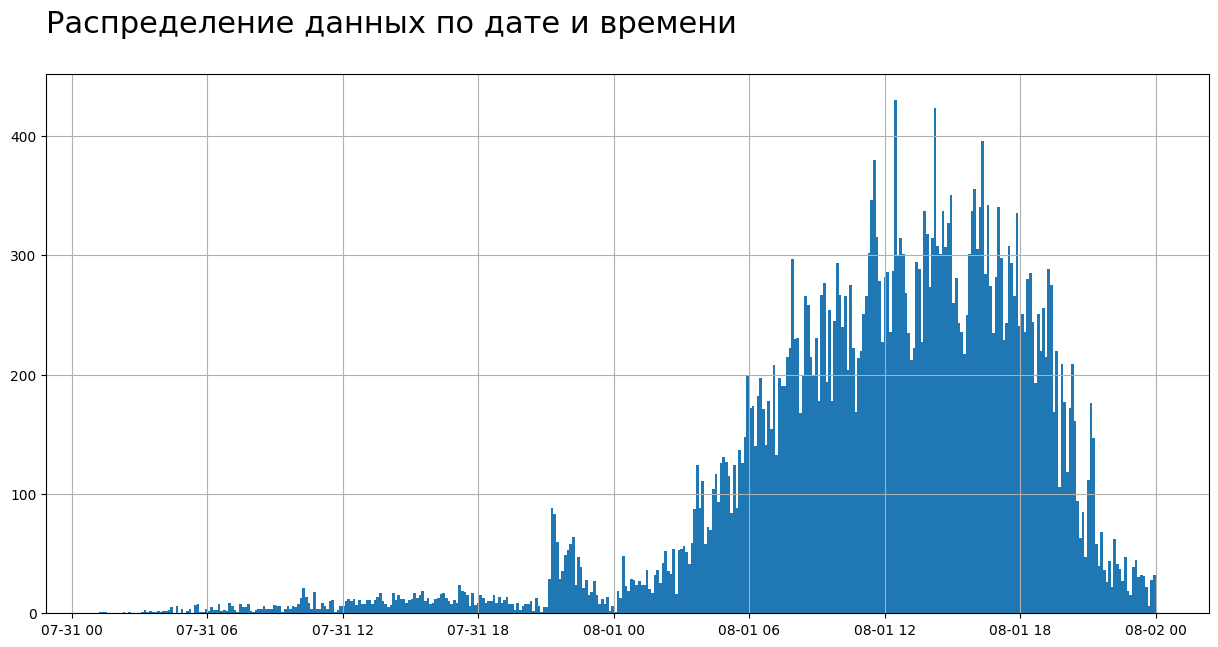

In [16]:
logs.query('"2019-08-02" > date > "2019-07-30"')['date_time'].hist(bins=400,  figsize=(15, 7))
plt.title('Распределение данных по дате и времени' + "\n", fontsize=22,  loc='left')
plt.show()

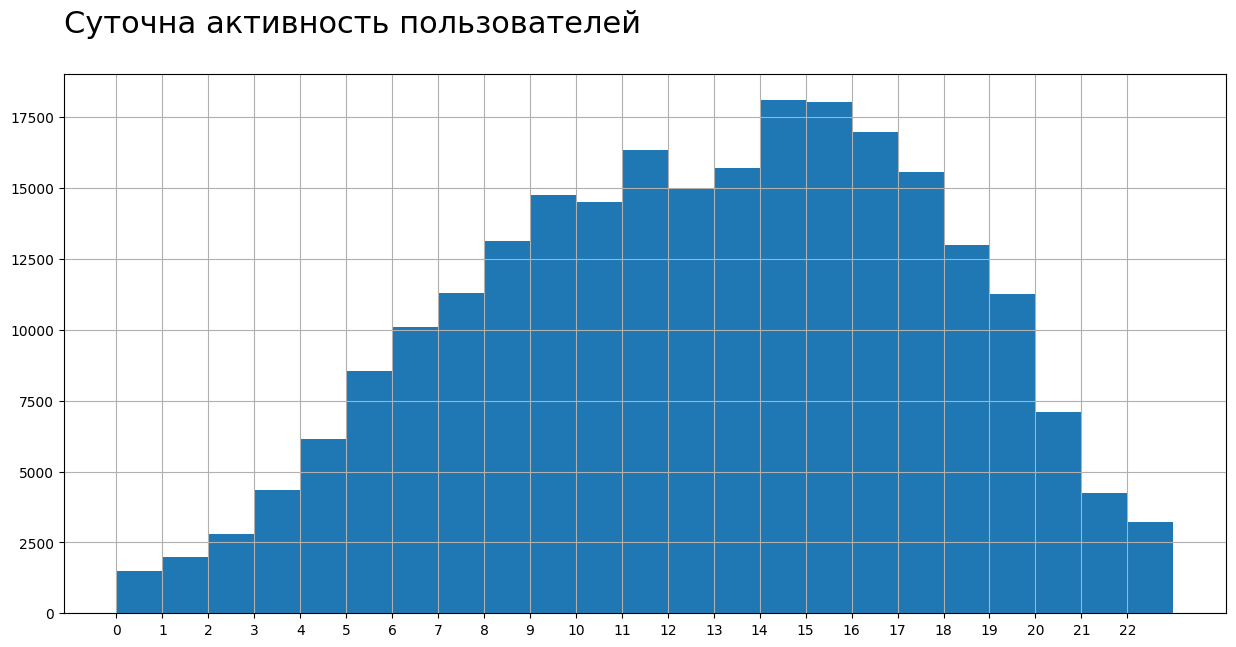

In [17]:
# суточная активность пользователей

logs['date_time'].dt.hour.hist(bins=23, figsize=(15, 7))
plt.xticks(range(0, 23))
plt.title('Суточна активность пользователей' + "\n", fontsize=22,  loc='left')
plt.show()

Мы видим, что до 1 августа 2019г количество данных намного меньше чем после этой даты во всех трёх группах. Это показывает, что есть неполные сведения за предшествующий период, которые могут исказить расчёты. Также, обращает на себя внимание суточная активность пользователей, которая достигает наивысших значений в районе 15:00.

Для того, чтобы производить полноценные вычисления удалим события до 1 августа 2019г и проверим какое количество событий и пользователей от общего числа, которые нам пришлось удалить.

In [18]:
# Удалённые данные
bad_logs = logs[logs['date'] < '2019-08-01']

# Расчёт доли удалённых событий
print('Доля удалённых событий: ', "{0:.2%}".format(len(bad_logs)/len(logs)))

# Уникальные пользователи в логе
num_users = logs['user_id'].nunique()

# Очищенные данные
logs = logs[logs['date'] > '2019-07-31'].reset_index(drop=True)

# Расчёт доли удалённых пользователей
print('Доля удалённых пользователей: ', "{0:.2%}".format((num_users - logs['user_id'].nunique())/num_users))


Доля удалённых событий:  1.16%
Доля удалённых пользователей:  0.23%


In [19]:
# Число уникальных пользователей в обновленном логе 

num_users = logs['user_id'].nunique()

print('Число уникальных пользователей в обновленном логе: ', num_users)

Число уникальных пользователей в обновленном логе:  7534


In [20]:
logs.shape

(240887, 5)

Выведем обновленные данные по количеству событий во времени в разрезе групп

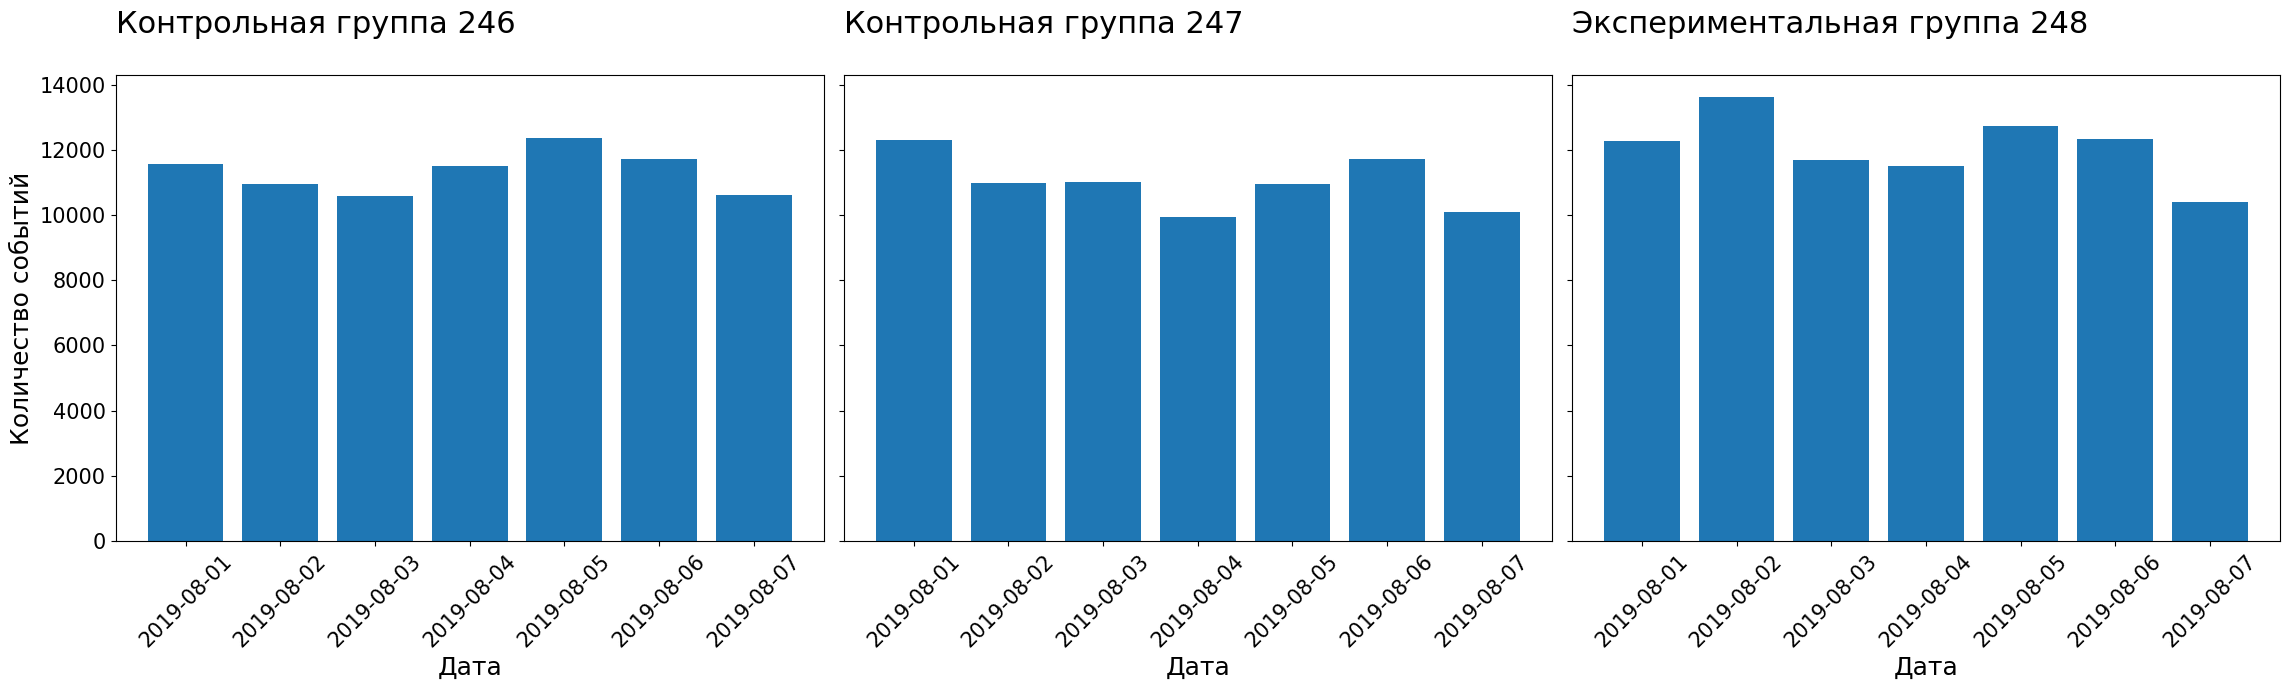

In [21]:
plot_grouped_events(logs)

In [22]:
# Проверим наличие пользователей во всех трёх группах

group_count = logs.groupby('group_id')['user_id'].nunique().to_frame().reset_index()
group_count

,group_id,user_id
0,246,2484
1,247,2513
2,248,2537


В результате изучения и проверки данных выявлено:
- 413 дубликатов, которые были успешно удалены;
- число уникальных значений в столбце `event_name` равно 5;
- число уникальных пользователей - 7534;
- среднее количество событий на одного пользователя: 32;
- три уникальных группы: 246, 247, 248;
- диапазон дат: 2019-07-25 - 2019-08-07;
- наличие одинаковых пользователей в разных группах не обнаружено;
- аномально низкое количество данных до 1 августа 2019 года. Эти данные были успешно удалены;
- доли удалённых событий и уникальных пользователей составили соответственно: 1,16% и 0,23%.

### Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются.

In [23]:
events_df = logs['event_name'].value_counts().to_frame().reset_index()
events_df.columns = ['event', 'total_events']
events_df

,event,total_events
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


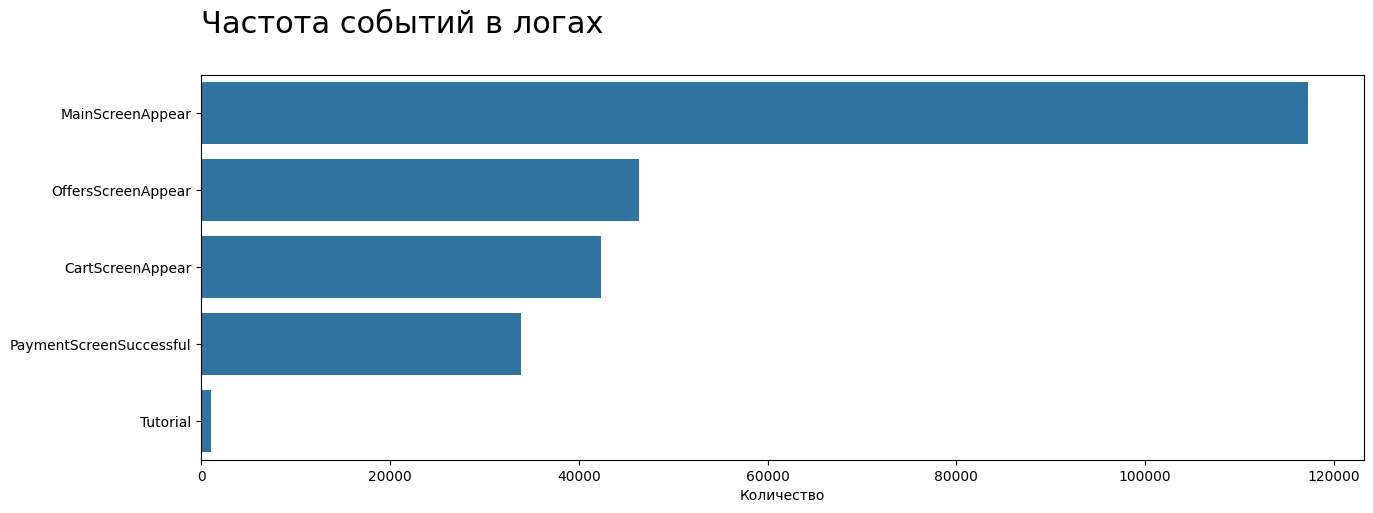

In [24]:
# Визуализируем данные

plt.figure(figsize=(15, 5))
ax = sns.barplot(x='total_events', y='event', data=events_df, orient='h')
ax.set_title('Частота событий в логах'+ "\n", fontsize=22, loc='left')
ax.set_xlabel('Количество') 
ax.set_ylabel('')
plt.show()

Посчитаем, сколько пользователей совершали каждое из этих событий и посчитаем долю пользователей, которые хоть раз его совершили.

In [25]:
unique_users_per_event = (logs.groupby('event_name')
                          .agg({'user_id':'nunique'})
                          .sort_values('user_id', ascending=False)
                          .reset_index())
unique_users_per_event['fraction,%'] = (100*unique_users_per_event['user_id']/num_users).round().astype(int)
unique_users_per_event

,event_name,user_id,"fraction,%"
0,MainScreenAppear,7419,98
1,OffersScreenAppear,4593,61
2,CartScreenAppear,3734,50
3,PaymentScreenSuccessful,3539,47
4,Tutorial,840,11


В воронке событий видим, что больше всего уникальных пользователей посещают главную страницу приложения, что естественно. На втором месте - страница товара, на третьем - корзина, на четвёртом - страница оплаты. Замыкает рейтинг страница со справкой приложения. Этот порядок действий является обычным для любого интернет-магазина. Событие, которое не является обязательным для совершения покупки - это страница со инструкцией. Для дальнейшей работы мы можем убрать данные связанные с этим событием из анализа воронки событий.

In [26]:
# Обновление данных

logs = logs[logs['event_name']!='Tutorial']

logs.shape

(239882, 5)

In [27]:
# обновление unique_users_per_event

unique_users_per_event = (logs.groupby('event_name')
                          .agg({'user_id':'nunique'})
                          .sort_values('user_id', ascending=False)
                          .reset_index())
unique_users_per_event['fraction,%'] = (100*unique_users_per_event['user_id']/num_users).round().astype(int)
unique_users_per_event

,event_name,user_id,"fraction,%"
0,MainScreenAppear,7419,98
1,OffersScreenAppear,4593,61
2,CartScreenAppear,3734,50
3,PaymentScreenSuccessful,3539,47


По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [28]:
funnel = unique_users_per_event

# доля пользователей, которая проходит на следующий шаг воронки
funnel['share_go,%'] = unique_users_per_event['user_id']/unique_users_per_event['user_id'].shift(1)
funnel['share_go,%'] = (100*funnel['share_go,%']).round().astype('Int64')

# доля потерь пользователей от предыдущего события
funnel['remaining,%'] = (funnel['user_id'].pct_change() * 100).round().astype('Int64')
funnel = funnel.fillna(100)
funnel = funnel[['event_name', 'user_id', 'share_go,%', 'remaining,%']]

funnel

,event_name,user_id,"share_go,%","remaining,%"
0,MainScreenAppear,7419,100,100
1,OffersScreenAppear,4593,62,-38
2,CartScreenAppear,3734,81,-19
3,PaymentScreenSuccessful,3539,95,-5


Построим воронку событий

In [29]:
fig = go.Figure(go.Funnel(y = funnel['event_name'],
                          x = funnel['user_id'],
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title_text='Воронка событий')
fig.show()

По результатам видим, что наибольшая доля потерь пользователей происходит на этапе перехода на страницу с товаром(38%). Это можно объяснить тем, что, возможно, пользователь не нашёл то, что искал, или его не удовлетворили цены товара. Может есть проблемы с отображением кнопки для добавления товара в корзину, разработчикам стоит проверить. Следующим этапом по размеру потерь клиентов происходит на стадии добавления товара в корзину(19%). Это может происходить из-за несоответствия ожидания посетителя в отношении характеристик товара или комментариев под этим товаром. Наименьшее число потерь посетителей происходит на этапе соверешения оплаты товара(5%)

Определим какая доля пользователей доходит до оплаты товара от первого события, т.е. после посещения главной страницы приложения.

In [30]:
print('Доля пользователей, которая доходит до оплаты товара: ', "{0:.1%}".format(funnel['user_id'].min()/funnel['user_id'].max()))

Доля пользователей, которая доходит до оплаты товара:  47.7%


В результате изучения воронки событий:
- Узнали, что существует пять разных событий в логах, а их порядок по частоте появления следующий:
	1. посещение главной страницы;
	2. посещение страницы с товаром;
	3. посещение страницы с корзиной товаров;
	4. посещение страницы оплаты товара;
	5. посещение страницы с инструкцией.

- Популярность по доле пользователей, которые хоть раз совершали событие, также соответствует вышеприведённому рангу.
- Выяснили, что наибольшее количество посетителей теряется на этапе перехода с главной страницы на страницу с товаром(38%), а наименьшее при переходе на старницу оплаты(5%).
- Доля пользователей прошедших все этапы воронки продаж составляет 47.7%.

### Изучение результатов эксперимента

Имеем следующие цифры количества пользователей в экспериментальных группах

In [31]:
exp_groups = logs.groupby('group_id')['user_id'].nunique().to_frame().reset_index()
exp_groups

,group_id,user_id
0,246,2483
1,247,2512
2,248,2535


Количество уникальных пользователей в трех группах различно. Согласно критерию успешного A/A-теста количество пользователей в группах должно различаться не более, чем на 1%. Посчитаем эту разницу между двумя контрольными группами: 247 и 246.

In [32]:
diff_groups = (exp_groups.loc[1,'user_id'] - exp_groups.loc[0,'user_id'])/exp_groups.loc[0,'user_id']
print('Количество пользователей в группах отличается на: ', "{0:.2%}".format(diff_groups))

Количество пользователей в группах отличается на:  1.17%


Для сравнения групп с помощью статистических тестов создадим функцию упрощающую проведение расчетов. На вход функция принимает два датафрейма, интересующее событие и уровень значимости.

In [33]:

def stat_func(df1, df2, event, alpha):

    # уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / 16
 
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([df1[df1['event_name'] == event]['user_id'].nunique(), 
                        df2[df2['event_name'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    print(success[0], success[1],n_users[0] , n_users[1])
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем z-статистику
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # задаем стандартное нормальное распределение
    distr = st.norm(0, 1)  

    # определяем двусторонний тест
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие:', event)
    print('p-value: ', "{0:.3f}".format(p_value))

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print('Не удалось отвергнуть нулевую гипотезу')
        
    print()


Создадим таблицу и отобразим количество пользователей в разрезе групп и событий

In [34]:
df_funnel = (logs
             .groupby(['group_id', 'event_name'])
             .agg({'user_id':'nunique'})
             .sort_values(['group_id','user_id']).reset_index())
df_funnel.columns = ['group_id', 'events', 'users']
df_funnel

,group_id,events,users
0,246,PaymentScreenSuccessful,1200
1,246,CartScreenAppear,1266
2,246,OffersScreenAppear,1542
3,246,MainScreenAppear,2450
4,247,PaymentScreenSuccessful,1158
5,247,CartScreenAppear,1238
6,247,OffersScreenAppear,1520
7,247,MainScreenAppear,2476
8,248,PaymentScreenSuccessful,1181
9,248,CartScreenAppear,1230


Проверим, есть ли статистически значимое отличие между двумя контрольными группами: 246 и 247, по всем событиям.
- Сформулируем нулевую гипотезу: "Различий между контрольными группами 246 и 247 в разрезе событий, нет".  
- Альтернативная гипотеза: "Существет различие между контрольными группами 246 и 247 в разрезе событий".  
- Уровень статистической значимости примем равным 0,05.


In [35]:
for event in df_funnel['events'].unique():
    stat_func(logs[logs['group_id'] == 246], logs[logs['group_id'] == 247], event, 0.05)

1200 1158 2483 2512
Событие: PaymentScreenSuccessful
p-value:  0.114
Не удалось отвергнуть нулевую гипотезу

1266 1238 2483 2512
Событие: CartScreenAppear
p-value:  0.229
Не удалось отвергнуть нулевую гипотезу

1542 1520 2483 2512
Событие: OffersScreenAppear
p-value:  0.248
Не удалось отвергнуть нулевую гипотезу

2450 2476 2483 2512
Событие: MainScreenAppear
p-value:  0.753
Не удалось отвергнуть нулевую гипотезу



Согласно проведённым тестам мы обнаружили, что при текущем уровне значимости в 0.05, статистически значимого различия между двумя контрольными группами нет. Это подтвердилось по всем событиям лога. Поэтому результаты A/A-теста можно считать правдоподобными и разбиение на группы работает корректно.

Далее сравним результаты с каждой из контрольных групп по отдельности по каждому событию, а также с объединенной контрольной группой:
- 246 <> 248
- 247 <> 248
- 246 + 247 <> 248

Сначала проверим, есть ли статистически значимое отличие между контрольной группой 246 и экспериментальной группой 248, т.е. с группой с изменённым шрифтом, по всем событиям.
- Сформулируем нулевую гипотезу: "Различий между контрольной группой 246 и экспериментальной группой 248 в разрезе событий, нет".  
- Альтернативная гипотеза: "Существет различие между контрольной группой 246 и экспериментальной группой 248 в разрезе событий".  
- Уровень статистической значимости примем равным 0,05.

In [36]:
for event in df_funnel['events'].unique():
    stat_func(logs[logs['group_id'] == 246], logs[logs['group_id'] == 248], event, 0.05)

1200 1181 2483 2535
Событие: PaymentScreenSuccessful
p-value:  0.217
Не удалось отвергнуть нулевую гипотезу

1266 1230 2483 2535
Событие: CartScreenAppear
p-value:  0.081
Не удалось отвергнуть нулевую гипотезу

1542 1531 2483 2535
Событие: OffersScreenAppear
p-value:  0.214
Не удалось отвергнуть нулевую гипотезу

2450 2493 2483 2535
Событие: MainScreenAppear
p-value:  0.339
Не удалось отвергнуть нулевую гипотезу



Согласно проведённым тестам мы обнаружили, что при текущем уровне значимости в 0.05, статистически значимого различия между контрольной группой 246 и экспериментальной группой 248 нет. Подтверждение гипотезы даёт основания считать, что эксперимент с изменённым шрифтом в мобильном приложении не влияет на конверсию.

Проверим, есть ли статистически значимое отличие между контрольной группой 247 и экспериментальной группой 248, т.е. с группой с изменённым шрифтом, по всем событиям.
- Сформулируем нулевую гипотезу: "Различий между контрольной группой 247 и экспериментальной группой 248 в разрезе событий, нет".  
- Альтернативная гипотеза: "Существет различие между контрольной группой 247 и экспериментальной группой 248 в разрезе событий".  
- Уровень статистической значимости примем равным 0,05.

In [37]:
for event in df_funnel['events'].unique():
    stat_func(logs[logs['group_id'] == 247], logs[logs['group_id'] == 248], event, 0.05)

1158 1181 2512 2535
Событие: PaymentScreenSuccessful
p-value:  0.728
Не удалось отвергнуть нулевую гипотезу

1238 1230 2512 2535
Событие: CartScreenAppear
p-value:  0.588
Не удалось отвергнуть нулевую гипотезу

1520 1531 2512 2535
Событие: OffersScreenAppear
p-value:  0.933
Не удалось отвергнуть нулевую гипотезу

2476 2493 2512 2535
Событие: MainScreenAppear
p-value:  0.519
Не удалось отвергнуть нулевую гипотезу



Согласно проведённым тестам мы обнаружили, что при текущем уровне значимости в 0.05, статистически значимого различия между контрольной группой 247 и экспериментальной группой 248 нет. Подтверждение гипотезы даёт основания считать, что эксперимент с изменённым шрифтом в мобильном приложении не влияет на конверсию.

Проверим, есть ли статистически значимое отличие между объединенными контрольными группами 246 + 247 и экспериментальной группой 248, т.е. с группой с изменённым шрифтом, по всем событиям.
- Сформулируем нулевую гипотезу: "Различий между объединенной контрольной группой 246 + 247 и экспериментальной группой 248 в разрезе событий, нет".  
- Альтернативная гипотеза: "Существет различие между объединенной контрольной группой 246 + 247 и экспериментальной группой 248 в разрезе событий".  
- Уровень статистической значимости примем равным 0,05.

In [38]:
for event in df_funnel['events'].unique():
    stat_func(logs[logs['group_id'] != 248], logs[logs['group_id'] == 248], event, 0.05)

2358 1181 4995 2535
Событие: PaymentScreenSuccessful
p-value:  0.611
Не удалось отвергнуть нулевую гипотезу

2504 1230 4995 2535
Событие: CartScreenAppear
p-value:  0.187
Не удалось отвергнуть нулевую гипотезу

3062 1531 4995 2535
Событие: OffersScreenAppear
p-value:  0.446
Не удалось отвергнуть нулевую гипотезу

4926 2493 4995 2535
Событие: MainScreenAppear
p-value:  0.349
Не удалось отвергнуть нулевую гипотезу



Согласно проведённым тестам мы обнаружили, что при текущем уровне значимости в 0.05, статистически значимого различия между объединенной контрольной группой 246 + 247 и экспериментальной группой 248 нет. Подтверждение гипотезы даёт основания считать, что эксперимент с изменённым шрифтом в мобильном приложении не влияет на конверсию.

### Общий итог

На этапе чтения данных выяснили, что:
- файл с данными содержит 244126 записей и 4 столбца;
- пропусков обнаружено не было.

Для дальнейшей работы мы изменили названия колонок, добавили колонки с временной меткой и датой, а также удалили колонку-донор с сырыми временными метками.  
В ходе изучения и проверки данных, нами были обнаружены и удалены 413 дубликатов.  
Также выяснили, что число уникальных событий равняется 5, а именно:
- посещение главной страницы приложения;
- посещение страницы с товаром;
- посещение страницы с корзиной;
- посещение страницы оплаты;
- посещение страницы с инструкцией. 
 
Из дальнейшего анализа страницу с инструкцией удалили т.к. её существование никак не влияет воронку событий.
Также выяснили, что число уникальных пользователей составляет 7534, среднее количество событий на одного пользователя составляет - 32.
Временной диапазон лога составляет период от 2019-07-25 до 2019-08-07. Т.к. мы выяснили, события до 1 августа 2019 - неполные, то данные за этот период нам пришлось удалить.  
У нас три уникальных группы, на которые были поделены все пользователи: две группы под номерами 246 и 247 - контрольные и 248 - экспериментальная.  
Доли удалённых событий и уникальных пользователей составили соответственно: 1,16% и 0,23%.
Мы обнаружили, что наибольшее количество посетителей теряется на этапе перехода с главной страницы на страницу с товаром(38%), а наименьшее при переходе на страницу оплаты(5%). Доля пользователей, прошедших все этапы воронки продаж составляет 47.7%.
Для того чтобы выяснить как изменение шрифтов влияет на конверсию нам было необходимо провести анализ A/A/B-теста, в котором необходимо сравнить совокупности пользователей в разрезе групп и событий. Но перед этим мы провели предварительный анализ A/A-теста двух контрольных групп, который не выявил различий между данными группами. Это свидетельствует, что дальнейшие результаты A/A/B-теста можно считать достоверными. Анализ результатов теста основывался на статистической значимости различий между двумя контрольными группами и одной экспериментальной.  
Были проведено 12 статистических анализов A/A/B-теста по каждой из трех групп в разрезе по четырём событиям:
- 4 анализа 246 и 248 групп;
- 4 анализа 247 и 248 групп;
- 4 анализа 246 + 247 и 248 групп.
 
Результаты всех тестов не подтвердили статистически значимых различий между контрольными и экспериментальной группами. Поэтому можно с уверенностью сказать, что изменение шрифтов в приложении не повлияло на конверсию пользователей.
